## Hyperparameter Tuning for MLP  
**Date:** May 15, 2025  

### Goal  
Find optimal values for `hidden_dim` and `learning_rate` for the MLP model.

### Fixed Parameters:
- `batch_size = 64`  
- `epochs = 500`  
- `output_dim = 1`

### Parameters to Tune:
- hidden_dim_choices = [64, 128, 192, 256, 384, 512] 
- `learning_rate`: continuous range from `1e-5` to `1e-1` (log scale)

### Sampling Strategy:
- `hidden_dim` is sampled from a fixed list
- `learning_rate` is sampled uniformly in log scale

### Evaluation Metric:
- `R²` on the test set

In [43]:
# 📦 Imports and Configuration

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [44]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

#DATA_PATH = "/kaggle/input/wind-pressure-prediction-2025/windloading_interference_base.csv"
#SAVE_ROOT = "/kaggle/working"

DATA_PATH = "/mnt/d/projects/wind_pressure_prediction_2025/data/processed/windloading_interference_base.csv"
SAVE_ROOT = "/mnt/d/projects/wind_pressure_prediction_2025/experiments"

TUNING_DIR = os.path.join(SAVE_ROOT, "tuning_mlp")
LOG_CSV_PATH = os.path.join(SAVE_ROOT, "experiments_log.csv")

LOG_DIR = os.path.join(SAVE_ROOT, "results", "logs")
WEIGHTS_DIR = os.path.join(SAVE_ROOT, "models", "weights")
CONFIG_DIR = os.path.join(SAVE_ROOT, "models", "configs")
METRICS_DIR = os.path.join(SAVE_ROOT, "results", "metrics")
FIGURES_DIR = os.path.join(SAVE_ROOT, "results", "figures")

#os.makedirs(LOG_DIR, exist_ok=True)
#os.makedirs(WEIGHTS_DIR, exist_ok=True)
#os.makedirs(CONFIG_DIR, exist_ok=True)
#os.makedirs(METRICS_DIR, exist_ok=True)
#os.makedirs(FIGURES_DIR, exist_ok=True)


# Create base result directories

os.makedirs(TUNING_DIR, exist_ok=True)

# Function to create a run-specific directory

def create_run_directory(hidden_dim, lr, batch_size=64, epochs=500, base_dir=TUNING_DIR):
    run_id = f"mlp_{hidden_dim}h_{lr:.0e}lr_{batch_size}bs_{epochs}ep"
    run_dir = os.path.join(base_dir, run_id)
    os.makedirs(run_dir, exist_ok=True)
    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir

In [45]:
# 📁 src/data/load_dataset.py
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [46]:
# 📁 src/metrics/regression_metrics.py
# ➤ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}

In [47]:
# 📁 src/models/mlp_model.py
# ➤ Definition of the MLP architecture 

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [48]:
# 📁 src/visualization/plot_metrics.py
# ➤ Visualization of prediction results and training loss

sns.set(style="whitegrid")

def plot_metrics(y_true, y_pred, train_loss_history, val_loss_history, save_dir, show=False):

    if hasattr(y_true, "detach"):
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, "detach"):
        y_pred = y_pred.detach().cpu().numpy()

    epochs = np.arange(1, len(train_loss_history) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
    # 1. Scatter
    axes[0].scatter(y_true, y_pred, alpha=0.5, color='royalblue')
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    axes[0].set_title("Predicted vs True, Cp")
    axes[0].set_xlabel("True")
    axes[0].set_ylabel("Predicted")

    # 2. Residuals Histogram
    errors = (y_pred - y_true).flatten() 
    sns.histplot(errors, bins=50, kde=True, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_title("Prediction Error Distribution, Cp")
    axes[1].set_xlabel("Error")
    axes[1].set_ylabel("Count")

    # 3. Train loss
    axes[2].plot(epochs, train_loss_history, label='Train Loss', color='green')
    axes[2].set_title("Training Loss, Cp")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Loss")
    axes[2].legend()

    # Save
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "loss_plot.png")
    plt.tight_layout()
    plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

    print(f"📊 Metric saved: {save_path}")
    return save_path


In [49]:
# 📁 src/tuning/train_mlp_function.py
# ➤ Training function for MLP model: used in Random Search and experiment tracking

def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1):

    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['Mean']]
    input_dim = X.shape[1]

    # ----------------------------
    # Split and tensor conversion
    # ----------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

    # ----------------------------
    # Device and model
    # ----------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🛠 Device: {device}")
    model = MLP(input_dim, hidden_dim, output_dim).to(device)
    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    # ----------------------------
    # Run directory
    # ----------------------------
    run_id, run_dir = create_run_directory(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=epochs
    )

    # ----------------------------
    # Save config
    # ----------------------------
    config = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "output_dim": output_dim,
        "lr": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "features": ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'],
        "targets": ['Mean']
    }
    with open(os.path.join(run_dir, "config.json"), "w") as f:
        json.dump(config, f, indent=4)

    # ----------------------------
    # Training loop
    # ----------------------------
    log_path = os.path.join(run_dir, "train_log.txt")
    with open(log_path, "w") as log_file:
        log_file.write("Epoch\tLoss\n")
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loss_history = []

        for epoch in tqdm(range(epochs), desc="Epochs"):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

            train_loss_history.append(loss.item())

            if (epoch + 1) % 10 == 0:
                log_str = f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}"
                print(log_str)
                log_file.write(f"{epoch+1}\t{loss.item():.6f}\n")

    # ----------------------------
    # Save weights
    # ----------------------------
    torch.save(model.state_dict(), os.path.join(run_dir, "weights.pth"))

    # ----------------------------
    # Evaluation and saving results
    # ----------------------------
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        metrics = evaluate_regression(y_test, y_pred)

    metrics_clean = {k: float(v) for k, v in metrics.items()}
    with open(os.path.join(run_dir, "metrics.json"), "w") as f:
        json.dump(metrics_clean, f, indent=4)

    print("📈 Evaluation metrics on test set:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    # ----------------------------
    # Plot results
    # ----------------------------
    plot_metrics(
        y_test,
        y_pred,
        train_loss_history=train_loss_history,
        val_loss_history=[],
        save_dir=run_dir,
        show=True
    )

    # ----------------------------
    # Append summary to global CSV log
    # ----------------------------
    with open(LOG_CSV_PATH, "a") as f:
        f.write(f"{run_id},{hidden_dim},{lr:.0e},{metrics['R2']:.4f},{metrics['MAE']:.4f},{metrics['MSE']:.6f}\n")

    return run_id, metrics_clean



🔁 Run 1/4
→ hidden_dim: 128, lr: 0.00500
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cpu
📂 Created run directory: /mnt/d/projects/wind_pressure_prediction_2025/experiments/tuning_mlp/mlp_128h_5e-03lr_64bs_500ep


Epochs:   2%|▏         | 12/500 [00:00<00:38, 12.72it/s]

Epoch [10/500], Loss: 12.3350


Epochs:   4%|▍         | 22/500 [00:01<00:37, 12.71it/s]

Epoch [20/500], Loss: 8.8252


Epochs:   6%|▋         | 32/500 [00:02<00:41, 11.37it/s]

Epoch [30/500], Loss: 1.1565


Epochs:   8%|▊         | 42/500 [00:03<00:39, 11.46it/s]

Epoch [40/500], Loss: 0.5199


Epochs:  10%|█         | 52/500 [00:04<00:39, 11.43it/s]

Epoch [50/500], Loss: 0.2789


Epochs:  12%|█▏        | 62/500 [00:05<00:37, 11.53it/s]

Epoch [60/500], Loss: 0.2621


Epochs:  14%|█▍        | 72/500 [00:06<00:38, 11.07it/s]

Epoch [70/500], Loss: 0.2233


Epochs:  16%|█▋        | 82/500 [00:06<00:36, 11.53it/s]

Epoch [80/500], Loss: 0.2054


Epochs:  18%|█▊        | 92/500 [00:07<00:36, 11.29it/s]

Epoch [90/500], Loss: 0.1894


Epochs:  20%|██        | 102/500 [00:08<00:35, 11.18it/s]

Epoch [100/500], Loss: 0.1696


Epochs:  22%|██▏       | 112/500 [00:09<00:35, 11.04it/s]

Epoch [110/500], Loss: 0.1508


Epochs:  24%|██▍       | 122/500 [00:10<00:35, 10.77it/s]

Epoch [120/500], Loss: 0.1372


Epochs:  26%|██▋       | 132/500 [00:11<00:33, 10.99it/s]

Epoch [130/500], Loss: 0.1272


Epochs:  28%|██▊       | 140/500 [00:12<00:34, 10.39it/s]

Epoch [140/500], Loss: 0.1221


Epochs:  30%|███       | 151/500 [00:13<00:38,  9.00it/s]

Epoch [150/500], Loss: 0.1170


Epochs:  32%|███▏      | 161/500 [00:14<00:39,  8.52it/s]

Epoch [160/500], Loss: 0.1161


Epochs:  34%|███▍      | 171/500 [00:15<00:37,  8.69it/s]

Epoch [170/500], Loss: 0.1115


Epochs:  36%|███▌      | 181/500 [00:17<00:35,  8.92it/s]

Epoch [180/500], Loss: 0.1103


Epochs:  38%|███▊      | 191/500 [00:18<00:33,  9.31it/s]

Epoch [190/500], Loss: 0.1087


Epochs:  40%|████      | 201/500 [00:19<00:32,  9.11it/s]

Epoch [200/500], Loss: 0.1073


Epochs:  42%|████▏     | 211/500 [00:20<00:32,  9.02it/s]

Epoch [210/500], Loss: 0.1063


Epochs:  44%|████▍     | 221/500 [00:21<00:30,  9.20it/s]

Epoch [220/500], Loss: 0.1052


Epochs:  46%|████▌     | 231/500 [00:24<01:05,  4.08it/s]

Epoch [230/500], Loss: 0.1041


Epochs:  48%|████▊     | 241/500 [00:25<00:32,  7.90it/s]

Epoch [240/500], Loss: 0.1033


Epochs:  50%|█████     | 251/500 [00:26<00:26,  9.51it/s]

Epoch [250/500], Loss: 0.1020


Epochs:  52%|█████▏    | 261/500 [00:27<00:25,  9.23it/s]

Epoch [260/500], Loss: 0.1008


Epochs:  54%|█████▍    | 271/500 [00:28<00:25,  9.09it/s]

Epoch [270/500], Loss: 0.0995


Epochs:  56%|█████▌    | 281/500 [00:29<00:22,  9.82it/s]

Epoch [280/500], Loss: 0.0980


Epochs:  58%|█████▊    | 291/500 [00:30<00:22,  9.12it/s]

Epoch [290/500], Loss: 0.0967


Epochs:  60%|██████    | 301/500 [00:31<00:21,  9.19it/s]

Epoch [300/500], Loss: 0.0929


Epochs:  62%|██████▏   | 311/500 [00:32<00:20,  9.37it/s]

Epoch [310/500], Loss: 0.0890


Epochs:  64%|██████▍   | 321/500 [00:33<00:18,  9.57it/s]

Epoch [320/500], Loss: 0.0879


Epochs:  66%|██████▌   | 331/500 [00:34<00:17,  9.60it/s]

Epoch [330/500], Loss: 0.0828


Epochs:  68%|██████▊   | 341/500 [00:35<00:16,  9.66it/s]

Epoch [340/500], Loss: 0.0811


Epochs:  70%|███████   | 351/500 [00:37<00:17,  8.70it/s]

Epoch [350/500], Loss: 0.0802


Epochs:  72%|███████▏  | 361/500 [00:38<00:15,  8.82it/s]

Epoch [360/500], Loss: 0.0786


Epochs:  74%|███████▍  | 371/500 [00:39<00:14,  8.85it/s]

Epoch [370/500], Loss: 0.0788


Epochs:  76%|███████▌  | 381/500 [00:40<00:12,  9.36it/s]

Epoch [380/500], Loss: 0.0756


Epochs:  78%|███████▊  | 391/500 [00:41<00:11,  9.46it/s]

Epoch [390/500], Loss: 0.0747


Epochs:  80%|████████  | 401/500 [00:42<00:11,  8.87it/s]

Epoch [400/500], Loss: 0.0738


Epochs:  82%|████████▏ | 411/500 [00:43<00:10,  8.84it/s]

Epoch [410/500], Loss: 0.0732


Epochs:  84%|████████▍ | 421/500 [00:44<00:09,  8.52it/s]

Epoch [420/500], Loss: 0.0724


Epochs:  86%|████████▌ | 431/500 [00:45<00:08,  8.17it/s]

Epoch [430/500], Loss: 0.0719


Epochs:  88%|████████▊ | 441/500 [00:47<00:06,  9.65it/s]

Epoch [440/500], Loss: 0.0733


Epochs:  90%|█████████ | 451/500 [00:48<00:05,  9.65it/s]

Epoch [450/500], Loss: 0.0725


Epochs:  92%|█████████▏| 461/500 [00:49<00:04,  9.39it/s]

Epoch [460/500], Loss: 0.0715


Epochs:  94%|█████████▍| 471/500 [00:50<00:03,  8.85it/s]

Epoch [470/500], Loss: 0.0700


Epochs:  96%|█████████▌| 481/500 [00:51<00:02,  8.70it/s]

Epoch [480/500], Loss: 0.0699


Epochs:  98%|█████████▊| 491/500 [00:52<00:01,  8.73it/s]

Epoch [490/500], Loss: 0.0697


Epochs: 100%|██████████| 500/500 [00:53<00:00,  9.31it/s]


Epoch [500/500], Loss: 0.0695
📈 Evaluation metrics on test set:
MSE: 0.0686
MAE: 0.1872
R2: 0.7230


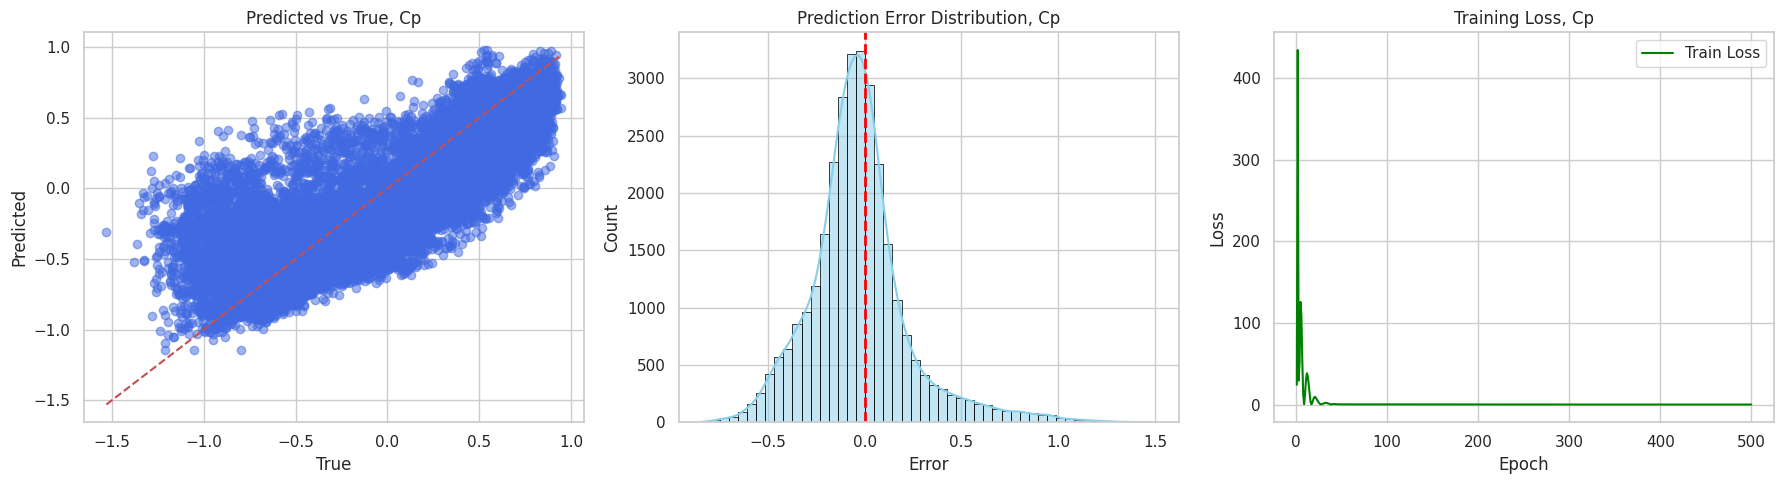

📊 Metric saved: /mnt/d/projects/wind_pressure_prediction_2025/experiments/tuning_mlp/mlp_128h_5e-03lr_64bs_500ep/loss_plot.png

🔁 Run 2/4
→ hidden_dim: 264, lr: 0.00100
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cpu
📂 Created run directory: /mnt/d/projects/wind_pressure_prediction_2025/experiments/tuning_mlp/mlp_264h_1e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:04<02:53,  2.82it/s]

Epoch [10/500], Loss: 15.5416


Epochs:   4%|▍         | 20/500 [00:07<02:29,  3.21it/s]

Epoch [20/500], Loss: 0.5814


Epochs:   6%|▌         | 30/500 [00:10<02:25,  3.24it/s]

Epoch [30/500], Loss: 1.3174


Epochs:   8%|▊         | 40/500 [00:14<02:39,  2.89it/s]

Epoch [40/500], Loss: 0.7686


Epochs:  10%|█         | 50/500 [00:17<02:24,  3.11it/s]

Epoch [50/500], Loss: 0.3099


Epochs:  12%|█▏        | 60/500 [00:20<02:18,  3.18it/s]

Epoch [60/500], Loss: 0.2244


Epochs:  14%|█▍        | 70/500 [00:23<02:17,  3.12it/s]

Epoch [70/500], Loss: 0.1977


Epochs:  16%|█▌        | 80/500 [00:26<02:12,  3.18it/s]

Epoch [80/500], Loss: 0.1781


Epochs:  18%|█▊        | 90/500 [00:30<02:24,  2.85it/s]

Epoch [90/500], Loss: 0.1626


Epochs:  20%|██        | 100/500 [00:33<02:06,  3.15it/s]

Epoch [100/500], Loss: 0.1419


Epochs:  22%|██▏       | 110/500 [00:37<02:20,  2.78it/s]

Epoch [110/500], Loss: 0.1334


Epochs:  24%|██▍       | 120/500 [00:41<02:01,  3.12it/s]

Epoch [120/500], Loss: 0.1270


Epochs:  26%|██▌       | 130/500 [00:43<01:44,  3.55it/s]

Epoch [130/500], Loss: 0.1221


Epochs:  28%|██▊       | 140/500 [00:46<01:41,  3.56it/s]

Epoch [140/500], Loss: 0.1184


Epochs:  30%|███       | 150/500 [00:49<01:42,  3.42it/s]

Epoch [150/500], Loss: 0.1156


Epochs:  32%|███▏      | 160/500 [00:52<01:35,  3.56it/s]

Epoch [160/500], Loss: 0.1134


Epochs:  34%|███▍      | 170/500 [00:55<01:40,  3.29it/s]

Epoch [170/500], Loss: 0.1127


Epochs:  36%|███▌      | 180/500 [00:58<01:39,  3.23it/s]

Epoch [180/500], Loss: 0.1103


Epochs:  38%|███▊      | 190/500 [01:01<01:37,  3.19it/s]

Epoch [190/500], Loss: 0.1092


Epochs:  40%|████      | 200/500 [01:04<01:31,  3.27it/s]

Epoch [200/500], Loss: 0.1080


Epochs:  42%|████▏     | 210/500 [01:07<01:23,  3.47it/s]

Epoch [210/500], Loss: 0.1069


Epochs:  44%|████▍     | 220/500 [01:12<01:30,  3.10it/s]

Epoch [220/500], Loss: 0.1059


Epochs:  46%|████▌     | 230/500 [01:15<01:19,  3.39it/s]

Epoch [230/500], Loss: 0.1049


Epochs:  48%|████▊     | 240/500 [01:18<01:14,  3.49it/s]

Epoch [240/500], Loss: 0.1040


Epochs:  50%|█████     | 250/500 [01:21<01:12,  3.47it/s]

Epoch [250/500], Loss: 0.1067


Epochs:  52%|█████▏    | 260/500 [01:24<01:08,  3.51it/s]

Epoch [260/500], Loss: 0.1039


Epochs:  54%|█████▍    | 270/500 [01:26<01:10,  3.28it/s]

Epoch [270/500], Loss: 0.1016


Epochs:  56%|█████▌    | 280/500 [01:30<01:06,  3.31it/s]

Epoch [280/500], Loss: 0.1009


Epochs:  58%|█████▊    | 290/500 [01:32<01:00,  3.46it/s]

Epoch [290/500], Loss: 0.0999


Epochs:  60%|██████    | 300/500 [01:35<00:59,  3.35it/s]

Epoch [300/500], Loss: 0.0990


Epochs:  62%|██████▏   | 310/500 [01:38<00:57,  3.33it/s]

Epoch [310/500], Loss: 0.0980


Epochs:  64%|██████▍   | 320/500 [01:43<02:15,  1.33it/s]

Epoch [320/500], Loss: 0.1074


Epochs:  66%|██████▌   | 330/500 [01:46<00:52,  3.22it/s]

Epoch [330/500], Loss: 0.0960


Epochs:  68%|██████▊   | 340/500 [01:49<00:46,  3.42it/s]

Epoch [340/500], Loss: 0.0946


Epochs:  70%|███████   | 350/500 [01:52<00:42,  3.54it/s]

Epoch [350/500], Loss: 0.0927


Epochs:  72%|███████▏  | 360/500 [01:55<00:40,  3.43it/s]

Epoch [360/500], Loss: 0.0914


Epochs:  74%|███████▍  | 370/500 [01:58<00:38,  3.38it/s]

Epoch [370/500], Loss: 0.0898


Epochs:  76%|███████▌  | 380/500 [02:00<00:35,  3.35it/s]

Epoch [380/500], Loss: 0.0885


Epochs:  78%|███████▊  | 390/500 [02:04<00:35,  3.14it/s]

Epoch [390/500], Loss: 0.0873


Epochs:  80%|████████  | 400/500 [02:06<00:27,  3.60it/s]

Epoch [400/500], Loss: 0.0863


Epochs:  82%|████████▏ | 410/500 [02:09<00:26,  3.34it/s]

Epoch [410/500], Loss: 0.0854


Epochs:  84%|████████▍ | 420/500 [02:13<00:24,  3.25it/s]

Epoch [420/500], Loss: 0.0909


Epochs:  86%|████████▌ | 430/500 [02:17<00:43,  1.62it/s]

Epoch [430/500], Loss: 0.0859


Epochs:  88%|████████▊ | 440/500 [02:20<00:18,  3.22it/s]

Epoch [440/500], Loss: 0.0842


Epochs:  90%|█████████ | 450/500 [02:23<00:14,  3.50it/s]

Epoch [450/500], Loss: 0.0832


Epochs:  92%|█████████▏| 460/500 [02:26<00:11,  3.48it/s]

Epoch [460/500], Loss: 0.0824


Epochs:  94%|█████████▍| 470/500 [02:29<00:09,  3.30it/s]

Epoch [470/500], Loss: 0.0819


Epochs:  96%|█████████▌| 480/500 [02:32<00:05,  3.54it/s]

Epoch [480/500], Loss: 0.0813


Epochs:  98%|█████████▊| 490/500 [02:35<00:03,  3.27it/s]

Epoch [490/500], Loss: 0.0807


Epochs: 100%|██████████| 500/500 [02:38<00:00,  3.16it/s]

Epoch [500/500], Loss: 0.0806
📈 Evaluation metrics on test set:
MSE: 0.0826
MAE: 0.2060
R2: 0.6634


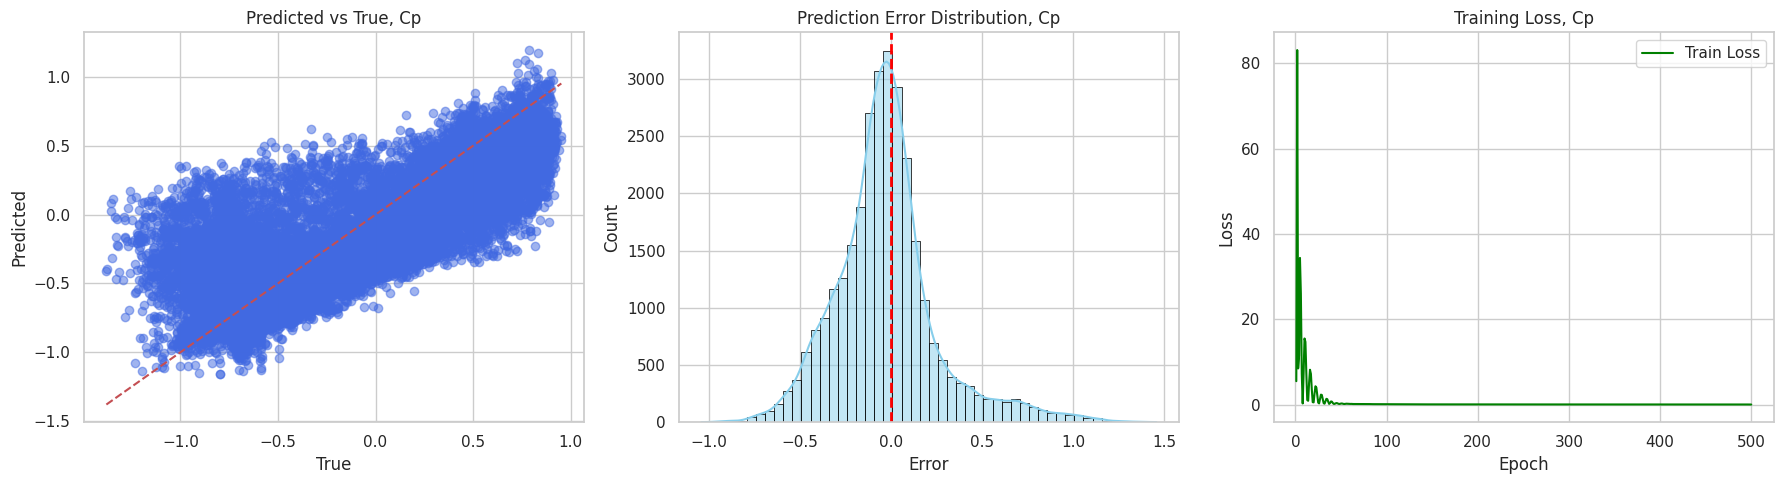

📊 Metric saved: /mnt/d/projects/wind_pressure_prediction_2025/experiments/tuning_mlp/mlp_264h_1e-03lr_64bs_500ep/loss_plot.png

🔁 Run 3/4
→ hidden_dim: 128, lr: 0.00100
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cpu
📂 Created run directory: /mnt/d/projects/wind_pressure_prediction_2025/experiments/tuning_mlp/mlp_128h_1e-03lr_64bs_500ep


Epochs:   2%|▏         | 12/500 [00:01<00:48, 10.08it/s]

Epoch [10/500], Loss: 6.2877


Epochs:   4%|▍         | 21/500 [00:02<00:52,  9.06it/s]

Epoch [20/500], Loss: 0.6899


Epochs:   6%|▌         | 31/500 [00:03<00:53,  8.75it/s]

Epoch [30/500], Loss: 0.3040


Epochs:   8%|▊         | 41/500 [00:04<00:51,  8.90it/s]

Epoch [40/500], Loss: 0.2654


Epochs:  10%|█         | 51/500 [00:05<00:48,  9.24it/s]

Epoch [50/500], Loss: 0.2303


Epochs:  12%|█▏        | 62/500 [00:06<00:43,  9.99it/s]

Epoch [60/500], Loss: 0.1951


Epochs:  14%|█▍        | 71/500 [00:07<00:43,  9.96it/s]

Epoch [70/500], Loss: 0.1869


Epochs:  16%|█▋        | 82/500 [00:08<00:42,  9.77it/s]

Epoch [80/500], Loss: 0.1802


Epochs:  18%|█▊        | 92/500 [00:11<03:34,  1.90it/s]

Epoch [90/500], Loss: 0.1688


Epochs:  20%|██        | 101/500 [00:12<00:53,  7.43it/s]

Epoch [100/500], Loss: 0.1581


Epochs:  22%|██▏       | 111/500 [00:13<00:43,  8.96it/s]

Epoch [110/500], Loss: 0.1494


Epochs:  24%|██▍       | 121/500 [00:14<00:44,  8.56it/s]

Epoch [120/500], Loss: 0.1381


Epochs:  26%|██▌       | 131/500 [00:15<00:38,  9.57it/s]

Epoch [130/500], Loss: 0.1307


Epochs:  28%|██▊       | 142/500 [00:16<00:34, 10.48it/s]

Epoch [140/500], Loss: 0.1251


Epochs:  30%|███       | 150/500 [00:17<00:33, 10.33it/s]

Epoch [150/500], Loss: 0.1209


Epochs:  32%|███▏      | 162/500 [00:18<00:33, 10.14it/s]

Epoch [160/500], Loss: 0.1179


Epochs:  34%|███▍      | 172/500 [00:19<00:31, 10.39it/s]

Epoch [170/500], Loss: 0.1151


Epochs:  36%|███▋      | 182/500 [00:20<00:31, 10.04it/s]

Epoch [180/500], Loss: 0.1134


Epochs:  38%|███▊      | 192/500 [00:21<00:30, 10.26it/s]

Epoch [190/500], Loss: 0.1117


Epochs:  40%|████      | 201/500 [00:22<00:32,  9.27it/s]

Epoch [200/500], Loss: 0.1103


Epochs:  42%|████▏     | 212/500 [00:23<00:29,  9.72it/s]

Epoch [210/500], Loss: 0.1091


Epochs:  44%|████▍     | 221/500 [00:24<00:28,  9.84it/s]

Epoch [220/500], Loss: 0.1080


Epochs:  46%|████▌     | 231/500 [00:25<00:27,  9.69it/s]

Epoch [230/500], Loss: 0.1070


Epochs:  48%|████▊     | 242/500 [00:26<00:24, 10.48it/s]

Epoch [240/500], Loss: 0.1058


Epochs:  50%|█████     | 252/500 [00:27<00:23, 10.34it/s]

Epoch [250/500], Loss: 0.1044


Epochs:  52%|█████▏    | 262/500 [00:28<00:25,  9.50it/s]

Epoch [260/500], Loss: 0.1017


Epochs:  54%|█████▍    | 271/500 [00:29<00:24,  9.25it/s]

Epoch [270/500], Loss: 0.0993


Epochs:  56%|█████▌    | 281/500 [00:31<00:24,  9.10it/s]

Epoch [280/500], Loss: 0.0970


Epochs:  58%|█████▊    | 291/500 [00:32<00:20, 10.26it/s]

Epoch [290/500], Loss: 0.0956


Epochs:  60%|██████    | 301/500 [00:32<00:18, 10.54it/s]

Epoch [300/500], Loss: 0.0940


Epochs:  62%|██████▏   | 311/500 [00:33<00:17, 10.53it/s]

Epoch [310/500], Loss: 0.0924


Epochs:  64%|██████▍   | 321/500 [00:34<00:17, 10.36it/s]

Epoch [320/500], Loss: 0.0912


Epochs:  66%|██████▌   | 331/500 [00:35<00:16,  9.99it/s]

Epoch [330/500], Loss: 0.0901


Epochs:  68%|██████▊   | 340/500 [00:36<00:16,  9.90it/s]

Epoch [340/500], Loss: 0.0891


Epochs:  70%|███████   | 351/500 [00:37<00:15,  9.66it/s]

Epoch [350/500], Loss: 0.0882


Epochs:  72%|███████▏  | 361/500 [00:38<00:14,  9.60it/s]

Epoch [360/500], Loss: 0.0885


Epochs:  74%|███████▍  | 371/500 [00:40<00:13,  9.72it/s]

Epoch [370/500], Loss: 0.0869


Epochs:  76%|███████▌  | 381/500 [00:41<00:13,  9.12it/s]

Epoch [380/500], Loss: 0.0860


Epochs:  78%|███████▊  | 391/500 [00:42<00:12,  8.89it/s]

Epoch [390/500], Loss: 0.0917


Epochs:  80%|████████  | 401/500 [00:43<00:10,  9.70it/s]

Epoch [400/500], Loss: 0.0910


Epochs:  82%|████████▏ | 411/500 [00:45<00:12,  7.34it/s]

Epoch [410/500], Loss: 0.0869


Epochs:  84%|████████▍ | 421/500 [00:47<00:08,  9.10it/s]

Epoch [420/500], Loss: 0.0853


Epochs:  86%|████████▌ | 431/500 [00:48<00:07,  9.42it/s]

Epoch [430/500], Loss: 0.0844


Epochs:  88%|████████▊ | 441/500 [00:49<00:06,  9.58it/s]

Epoch [440/500], Loss: 0.0837


Epochs:  90%|█████████ | 452/500 [00:50<00:04, 10.30it/s]

Epoch [450/500], Loss: 0.0832


Epochs:  92%|█████████▏| 462/500 [00:51<00:03, 10.13it/s]

Epoch [460/500], Loss: 0.0827


Epochs:  94%|█████████▍| 470/500 [00:52<00:02, 10.25it/s]

Epoch [470/500], Loss: 0.0823


Epochs:  96%|█████████▌| 481/500 [00:53<00:02,  9.22it/s]

Epoch [480/500], Loss: 0.0836


Epochs:  98%|█████████▊| 490/500 [00:54<00:00, 10.14it/s]

Epoch [490/500], Loss: 0.0832


Epochs: 100%|██████████| 500/500 [00:55<00:00,  9.07it/s]


Epoch [500/500], Loss: 0.0820
📈 Evaluation metrics on test set:
MSE: 0.0820
MAE: 0.1983
R2: 0.6693


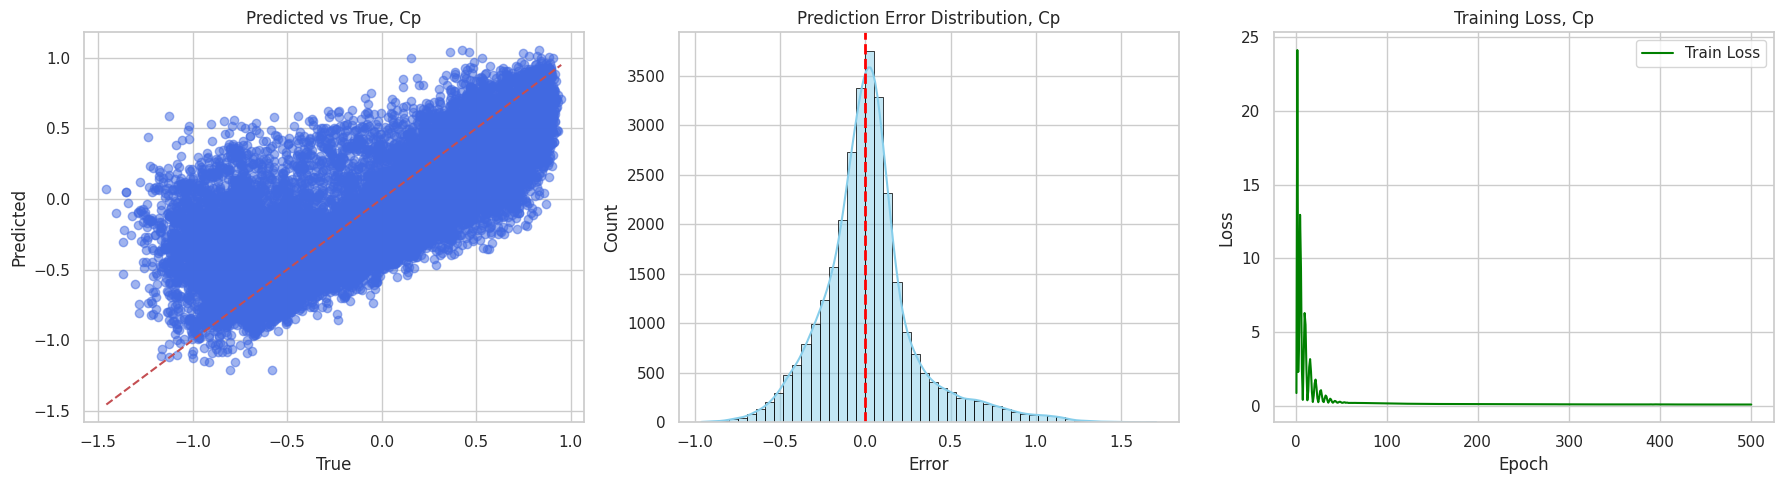

📊 Metric saved: /mnt/d/projects/wind_pressure_prediction_2025/experiments/tuning_mlp/mlp_128h_1e-03lr_64bs_500ep/loss_plot.png

🔁 Run 4/4
→ hidden_dim: 128, lr: 0.00500
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cpu
📂 Created run directory: /mnt/d/projects/wind_pressure_prediction_2025/experiments/tuning_mlp/mlp_128h_5e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:48, 10.20it/s]

Epoch [10/500], Loss: 2.8646


Epochs:   4%|▍         | 22/500 [00:02<00:47, 10.04it/s]

Epoch [20/500], Loss: 3.4668


Epochs:   6%|▋         | 32/500 [00:03<00:44, 10.41it/s]

Epoch [30/500], Loss: 0.7603


Epochs:   8%|▊         | 40/500 [00:03<00:44, 10.45it/s]

Epoch [40/500], Loss: 0.2326


Epochs:  10%|█         | 52/500 [00:05<00:42, 10.59it/s]

Epoch [50/500], Loss: 0.2450


Epochs:  12%|█▏        | 61/500 [00:06<00:47,  9.16it/s]

Epoch [60/500], Loss: 0.2489


Epochs:  14%|█▍        | 71/500 [00:07<00:46,  9.25it/s]

Epoch [70/500], Loss: 0.2097


Epochs:  16%|█▌        | 81/500 [00:08<00:46,  9.06it/s]

Epoch [80/500], Loss: 0.2030


Epochs:  18%|█▊        | 92/500 [00:09<00:39, 10.37it/s]

Epoch [90/500], Loss: 0.1849


Epochs:  20%|██        | 100/500 [00:10<00:38, 10.41it/s]

Epoch [100/500], Loss: 0.1672


Epochs:  22%|██▏       | 112/500 [00:11<00:37, 10.47it/s]

Epoch [110/500], Loss: 0.1485


Epochs:  24%|██▍       | 122/500 [00:12<00:35, 10.65it/s]

Epoch [120/500], Loss: 0.1370


Epochs:  26%|██▋       | 132/500 [00:13<00:37,  9.93it/s]

Epoch [130/500], Loss: 0.1286


Epochs:  28%|██▊       | 141/500 [00:14<00:37,  9.55it/s]

Epoch [140/500], Loss: 0.1217


Epochs:  30%|███       | 151/500 [00:15<00:37,  9.39it/s]

Epoch [150/500], Loss: 0.1165


Epochs:  32%|███▏      | 161/500 [00:16<00:40,  8.34it/s]

Epoch [160/500], Loss: 0.1124


Epochs:  34%|███▍      | 172/500 [00:17<00:32, 10.11it/s]

Epoch [170/500], Loss: 0.1100


Epochs:  36%|███▋      | 182/500 [00:18<00:30, 10.45it/s]

Epoch [180/500], Loss: 0.1066


Epochs:  38%|███▊      | 192/500 [00:19<00:29, 10.52it/s]

Epoch [190/500], Loss: 0.1040


Epochs:  40%|████      | 200/500 [00:20<00:29, 10.34it/s]

Epoch [200/500], Loss: 0.0992


Epochs:  42%|████▏     | 211/500 [00:21<00:31,  9.16it/s]

Epoch [210/500], Loss: 0.0937


Epochs:  44%|████▍     | 221/500 [00:22<00:29,  9.32it/s]

Epoch [220/500], Loss: 0.0900


Epochs:  46%|████▌     | 231/500 [00:23<00:28,  9.40it/s]

Epoch [230/500], Loss: 0.0883


Epochs:  48%|████▊     | 240/500 [00:24<00:27,  9.56it/s]

Epoch [240/500], Loss: 0.0861


Epochs:  50%|█████     | 251/500 [00:25<00:24,  9.97it/s]

Epoch [250/500], Loss: 0.0849


Epochs:  52%|█████▏    | 261/500 [00:26<00:25,  9.53it/s]

Epoch [260/500], Loss: 0.0837


Epochs:  54%|█████▍    | 271/500 [00:27<00:23,  9.59it/s]

Epoch [270/500], Loss: 0.0834


Epochs:  56%|█████▌    | 281/500 [00:29<00:24,  8.93it/s]

Epoch [280/500], Loss: 0.0826


Epochs:  58%|█████▊    | 291/500 [00:30<00:22,  9.17it/s]

Epoch [290/500], Loss: 0.0818


Epochs:  60%|██████    | 301/500 [00:31<00:21,  9.17it/s]

Epoch [300/500], Loss: 0.0808


Epochs:  62%|██████▏   | 311/500 [00:32<00:20,  9.44it/s]

Epoch [310/500], Loss: 0.0801


Epochs:  64%|██████▍   | 321/500 [00:33<00:19,  9.03it/s]

Epoch [320/500], Loss: 0.0796


Epochs:  66%|██████▌   | 331/500 [00:34<00:17,  9.80it/s]

Epoch [330/500], Loss: 0.0792


Epochs:  68%|██████▊   | 342/500 [00:35<00:16,  9.82it/s]

Epoch [340/500], Loss: 0.0788


Epochs:  70%|███████   | 352/500 [00:36<00:14, 10.14it/s]

Epoch [350/500], Loss: 0.0798


Epochs:  72%|███████▏  | 361/500 [00:37<00:14,  9.47it/s]

Epoch [360/500], Loss: 0.0783


Epochs:  74%|███████▍  | 371/500 [00:38<00:13,  9.57it/s]

Epoch [370/500], Loss: 0.0775


Epochs:  76%|███████▌  | 381/500 [00:39<00:13,  9.11it/s]

Epoch [380/500], Loss: 0.0771


Epochs:  78%|███████▊  | 391/500 [00:40<00:11,  9.41it/s]

Epoch [390/500], Loss: 0.0765


Epochs:  80%|████████  | 401/500 [00:41<00:10,  9.32it/s]

Epoch [400/500], Loss: 0.0763


Epochs:  82%|████████▏ | 411/500 [00:42<00:09,  9.55it/s]

Epoch [410/500], Loss: 0.0759


Epochs:  84%|████████▍ | 421/500 [00:43<00:08,  8.88it/s]

Epoch [420/500], Loss: 0.0757


Epochs:  86%|████████▌ | 431/500 [00:44<00:07,  9.30it/s]

Epoch [430/500], Loss: 0.0753


Epochs:  88%|████████▊ | 442/500 [00:46<00:06,  9.46it/s]

Epoch [440/500], Loss: 0.0749


Epochs:  90%|█████████ | 451/500 [00:47<00:05,  9.37it/s]

Epoch [450/500], Loss: 0.0748


Epochs:  92%|█████████▏| 461/500 [00:48<00:04,  9.49it/s]

Epoch [460/500], Loss: 0.0747


Epochs:  94%|█████████▍| 471/500 [00:49<00:03,  8.70it/s]

Epoch [470/500], Loss: 0.0744


Epochs:  96%|█████████▌| 481/500 [00:50<00:02,  8.52it/s]

Epoch [480/500], Loss: 0.0746


Epochs:  98%|█████████▊| 491/500 [00:51<00:01,  8.11it/s]

Epoch [490/500], Loss: 0.0733


Epochs: 100%|██████████| 500/500 [00:52<00:00,  9.47it/s]


Epoch [500/500], Loss: 0.0732
📈 Evaluation metrics on test set:
MSE: 0.0730
MAE: 0.1880
R2: 0.7045


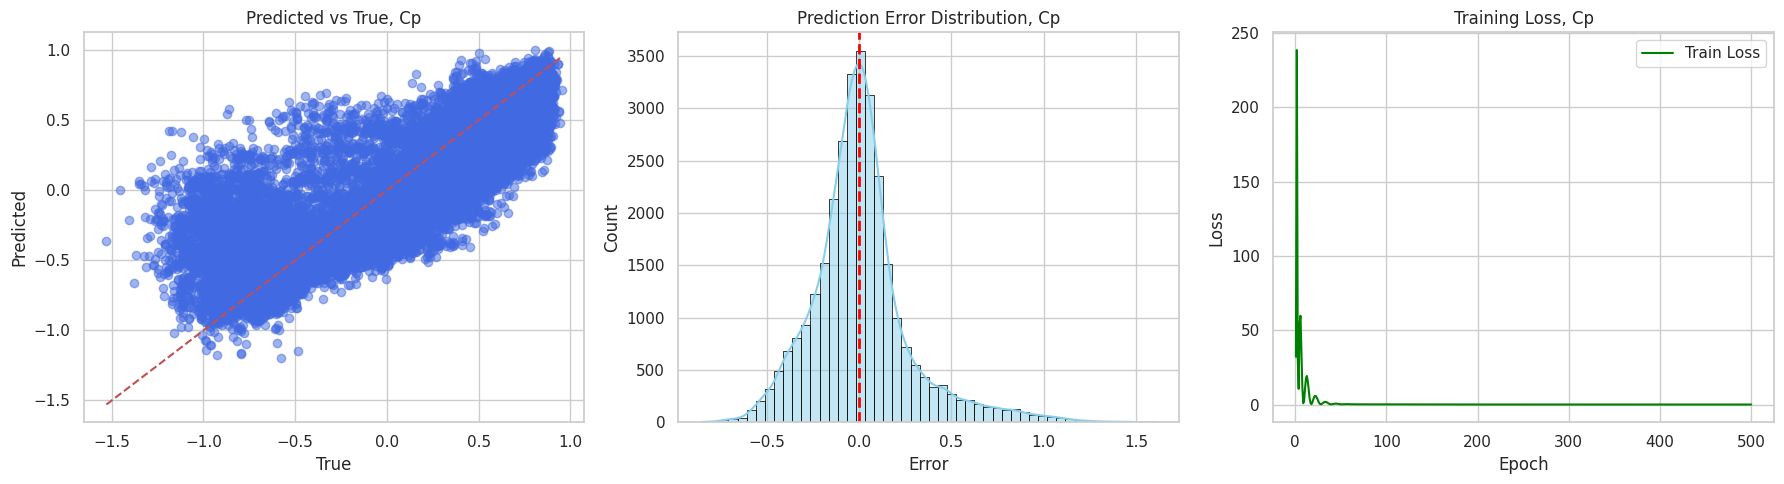

📊 Metric saved: /mnt/d/projects/wind_pressure_prediction_2025/experiments/tuning_mlp/mlp_128h_5e-03lr_64bs_500ep/loss_plot.png


In [50]:
# 📁 src/tuning/random_search_mlp.py
# ➤ Random Search for MLP model: selects hyperparameters and launches training

# 🔧 Hyperparameter options
#hidden_dim_choices = [64, 128, 192, 256, 384, 512]
#lr_choices = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]

hidden_dim_choices = [128, 264]
lr_choices = [ 1e-3, 5e-3]

# 📌 Fixed parameters
EPOCHS = 500
BATCH_SIZE = 64
OUTPUT_DIM = 1
#N_RUNS = 10  # Total number of runs
N_RUNS = 4  # Total number of runs

# 🧪 Random Search loop
for run in range(N_RUNS):
    # Randomly select hyperparameters
    hidden_dim = random.choice(hidden_dim_choices)
    lr = random.choice(lr_choices)

    # Display current configuration
    print(f"\n🔁 Run {run + 1}/{N_RUNS}")
    print(f"→ hidden_dim: {hidden_dim}, lr: {lr:.5f}")

    # Train model with current hyperparameters
    train_mlp(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        output_dim=OUTPUT_DIM
    )

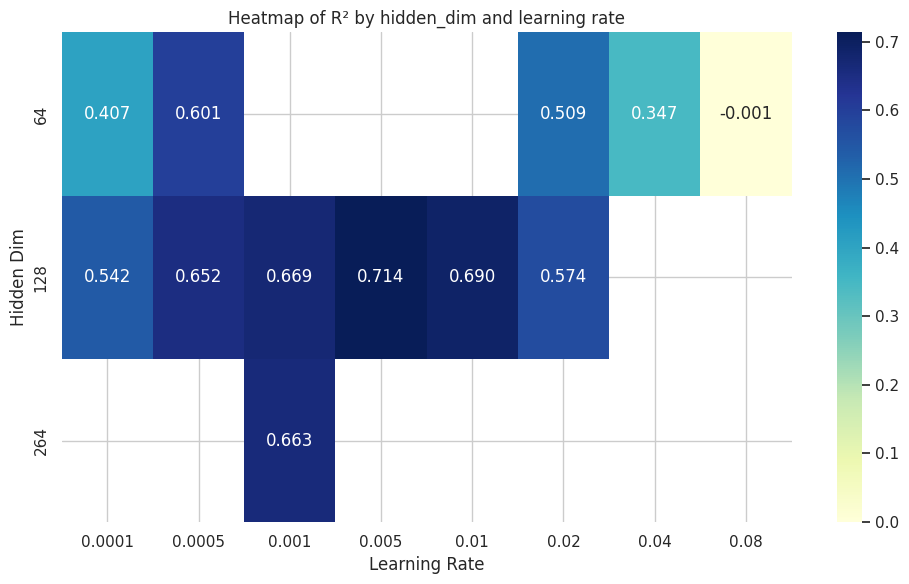


🏆 Best result:
Run ID      : mlp_128h_5e-03lr_64bs_500ep
Hidden Dim  : 128
Learning Rate: 0.00500
R²          : 0.7230
MAE         : 0.1872
MSE         : 0.068606

📌 R² threshold (95% of max): 0.6868
🔍 Found 3 stable candidates:

    hidden_dim     lr      R2     MAE       MSE
26         128  0.005  0.7230  0.1872  0.068606
29         128  0.005  0.7045  0.1880  0.072963
4          128  0.010  0.6902  0.1997  0.076864


In [51]:
# 📁 src/tuning/visualize_search_results.py
# ➤ Heatmap visualization of R² scores across hidden_dim and learning rate combinations

# 📥 Load experiments log
log_path = "experiments/experiments_log.csv"
df_log = pd.read_csv(LOG_CSV_PATH, header=None)
df_log.columns = ["run_id", "hidden_dim", "lr", "R2", "MAE", "MSE"]

# 📊 Pivot table for heatmap
pivot_table = df_log.pivot_table(
    values="R2",
    index="hidden_dim",
    columns="lr",
    aggfunc="mean"  # handles repeated runs with same params
)

# 🔥 Draw heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Heatmap of R² by hidden_dim and learning rate")
plt.xlabel("Learning Rate")
plt.ylabel("Hidden Dim")
plt.tight_layout()
plt.show()

# 🏆 Show best configuration
best_row = df_log.loc[df_log["R2"].idxmax()]
print("\n🏆 Best result:")
print(f"Run ID      : {best_row['run_id']}")
print(f"Hidden Dim  : {int(best_row['hidden_dim'])}")
print(f"Learning Rate: {best_row['lr']:.5f}")
print(f"R²          : {best_row['R2']:.4f}")
print(f"MAE         : {best_row['MAE']:.4f}")
print(f"MSE         : {best_row['MSE']:.6f}")

# ------------------------------
# 📊 Зона стабильных параметров по R²
# ------------------------------

# 1. Максимальное значение R²
r2_max = df_log["R2"].max()

# 2. Порог: 95% от максимума
threshold = r2_max * 0.95
print(f"\n📌 R² threshold (95% of max): {threshold:.4f}")

# 3. Отбираем устойчиво хорошие параметры
stable_zone = df_log[df_log["R2"] >= threshold]
print(f"🔍 Found {len(stable_zone)} stable candidates:\n")

# 4. Выводим таблицу устойчивых параметров
print(stable_zone.sort_values("R2", ascending=False)[["hidden_dim", "lr", "R2", "MAE", "MSE"]])

